# E-Commerce Product Review Sentiment Classification using RNN

## Author: Ronald Li
We build a Recurrent Neural Network (RNN) to classify e‑commerce product reviews as Positive or Negative, leveraging the fact that RNNs are well‑suited for sequential text data where word order matters. Later, we improve the model by switching to an LSTM architecture, handling the strong class imbalance with a class‑weighted loss, and adding early stopping to reduce overfitting and boost performance on minority (negative) reviews.

## Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


## Load and Explore the Dataset

We'll load the Amazon product reviews dataset. The dataset contains reviews with ratings (1-5 stars). 
We'll convert this to binary sentiment: ratings 4-5 are Positive (1), ratings 1-3 are Negative (0).

In [3]:
df = pd.read_csv('amazon_reviews.csv')

print(f"Total reviews in dataset: {len(df)}")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nMissing values:")
print(f"  reviewText: {df['reviewText'].isna().sum()}")
print(f"  overall: {df['overall'].isna().sum()}")

# Remove rows with missing review text
df = df.dropna(subset=['reviewText', 'overall'])
print(f"\nDataset after removing missing values: {len(df)} reviews")

# Convert ratings to binary sentiment
# Ratings 4-5: Positive (1), Ratings 1-3: Negative (0)
df['sentiment'] = (df['overall'] >= 4.0).astype(int)

print(f"\nRating distribution:")
print(df['overall'].value_counts().sort_index())
print(f"\nSentiment distribution:")
print(df['sentiment'].value_counts())
print(f"  Positive (1): {(df['sentiment'] == 1).sum()} ({(df['sentiment'] == 1).sum() / len(df) * 100:.1f}%)")
print(f"  Negative (0): {(df['sentiment'] == 0).sum()} ({(df['sentiment'] == 0).sum() / len(df) * 100:.1f}%)")

print(f"\n{'='*80}")
print("Sample Positive Reviews:")
print('='*80)
for i, row in df[df['sentiment'] == 1].head(3).iterrows():
    print(f"Rating: {row['overall']} | Review: {row['reviewText'][:100]}...")
    
print(f"\n{'='*80}")
print("Sample Negative Reviews:")
print('='*80)
for i, row in df[df['sentiment'] == 0].head(3).iterrows():
    print(f"Rating: {row['overall']} | Review: {row['reviewText'][:100]}...")

Total reviews in dataset: 4915

Dataset shape: (4915, 12)

Column names: ['Unnamed: 0', 'reviewerName', 'overall', 'reviewText', 'reviewTime', 'day_diff', 'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound']

First few rows:
   Unnamed: 0  reviewerName  overall  \
0           0           NaN      4.0   
1           1          0mie      5.0   
2           2           1K3      4.0   
3           3           1m2      5.0   
4           4  2&amp;1/2Men      5.0   

                                          reviewText  reviewTime  day_diff  \
0                                         No issues.  2014-07-23       138   
1  Purchased this for my device, it worked as adv...  2013-10-25       409   
2  it works as expected. I should have sprung for...  2012-12-23       715   
3  This think has worked out great.Had a diff. br...  2013-11-21       382   
4  Bought it with Retail Packaging, arrived legit...  2013-07-13       513   

   help

## Text Preprocessing

We need to:
1. Clean the text (remove special characters, lowercase)
2. Tokenize the reviews (convert words to tokens)
3. Build a vocabulary (map words to unique indices)
4. Convert text to sequences of indices
5. Pad sequences to a fixed length

In [4]:
def clean_text(text):
    """Clean and normalize text"""
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join(text.split())
    return text

df['cleaned_review'] = df['reviewText'].apply(clean_text)

df = df[df['cleaned_review'].str.len() > 0]

print(f"Dataset after cleaning: {len(df)} reviews")

Dataset after cleaning: 4914 reviews


In [5]:
def tokenize(text):
    """Split text into words"""
    return text.split()

df['tokens'] = df['cleaned_review'].apply(tokenize)

all_words = []
for tokens in df['tokens']:
    all_words.extend(tokens)

word_counts = Counter(all_words)
print(f"Total words: {len(all_words)}")
print(f"Total unique words: {len(word_counts)}")

# Filter vocabulary: keep words that appear at least 2 times
min_word_freq = 2
filtered_word_counts = {word: count for word, count in word_counts.items() if count >= min_word_freq}

print(f"Vocabulary size after filtering (min_freq={min_word_freq}): {len(filtered_word_counts)}")
print(f"\nMost common words:")
for word, count in Counter(filtered_word_counts).most_common(20):
    print(f"  {word}: {count}")

# Create word-to-index mapping (reserve 0 for padding, 1 for unknown words)
vocab = {'<PAD>': 0, '<UNK>': 1}
for word in filtered_word_counts.keys():
    vocab[word] = len(vocab)

vocab_size = len(vocab)
print(f"\nFinal vocabulary size (including <PAD> and <UNK>): {vocab_size}")

Total words: 243009
Total unique words: 9826
Vocabulary size after filtering (min_freq=2): 4215

Most common words:
  the: 9084
  i: 8122
  and: 7586
  it: 6838
  to: 6139
  a: 5589
  my: 5057
  card: 4603
  this: 4494
  for: 4035
  in: 3377
  of: 3369
  is: 3111
  with: 3057
  on: 2221
  have: 2153
  that: 1933
  gb: 1725
  phone: 1685
  was: 1644

Final vocabulary size (including <PAD> and <UNK>): 4217


In [6]:
# Convert tokens to sequences of indices
def tokens_to_sequence(tokens, vocab):
    """Convert list of tokens to list of indices"""
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

df['sequence'] = df['tokens'].apply(lambda x: tokens_to_sequence(x, vocab))

# Analyze sequence lengths
sequence_lengths = [len(seq) for seq in df['sequence']]
print(f"Sequence length statistics:")
print(f"  Min: {min(sequence_lengths)}")
print(f"  Max: {max(sequence_lengths)}")
print(f"  Mean: {np.mean(sequence_lengths):.1f}")
print(f"  Median: {np.median(sequence_lengths):.1f}")
print(f"  90th percentile: {np.percentile(sequence_lengths, 90):.1f}")
print(f"  95th percentile: {np.percentile(sequence_lengths, 95):.1f}")

# Set a fixed sequence length (truncate long reviews, pad short ones)
# Using 95th percentile as a good balance
sequence_length = int(np.percentile(sequence_lengths, 95))
print(f"\nSetting fixed sequence length to: {sequence_length}")

# Pad sequences to fixed length
def pad_sequence(sequence, max_len, pad_value=0):
    """Pad or truncate sequence to max_len"""
    if len(sequence) >= max_len:
        return sequence[:max_len]
    else:
        return sequence + [pad_value] * (max_len - len(sequence))

df['padded_sequence'] = df['sequence'].apply(lambda x: pad_sequence(x, sequence_length))

print(f"\nAll sequences padded to length: {sequence_length}")
print(f"\nSample padded sequences:")
for i in range(2):
    print(f"\nReview: {df['reviewText'].iloc[i][:60]}...")
    print(f"Sentiment: {df['sentiment'].iloc[i]}")
    print(f"Sequence length: {len(df['sequence'].iloc[i])}")
    print(f"Padded sequence (first 20): {df['padded_sequence'].iloc[i][:20]}")

Sequence length statistics:
  Min: 1
  Max: 1515
  Mean: 49.5
  Median: 32.0
  90th percentile: 96.0
  95th percentile: 131.0

Setting fixed sequence length to: 131

All sequences padded to length: 131

Sample padded sequences:

Review: No issues....
Sentiment: 1
Sequence length: 2
Padded sequence (first 20): [2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Review: Purchased this for my device, it worked as advertised. You c...
Sentiment: 1
Sequence length: 31
Padded sequence (first 20): [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


## Train/Test Split

Split the data into training and testing sets (80% train, 20% test)

In [7]:
X = np.array(df['padded_sequence'].tolist())
y = np.array(df['sentiment'].values)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nTraining sentiment distribution:")
print(f"  Positive: {np.sum(y_train == 1)} ({np.sum(y_train == 1) / len(y_train) * 100:.1f}%)")
print(f"  Negative: {np.sum(y_train == 0)} ({np.sum(y_train == 0) / len(y_train) * 100:.1f}%)")
print(f"\nTesting sentiment distribution:")
print(f"  Positive: {np.sum(y_test == 1)} ({np.sum(y_test == 1) / len(y_test) * 100:.1f}%)")
print(f"  Negative: {np.sum(y_test == 0)} ({np.sum(y_test == 0) / len(y_test) * 100:.1f}%)")

X shape: (4914, 131)
y shape: (4914,)

Training set: 3931 samples
Testing set: 983 samples

Training sentiment distribution:
  Positive: 3558 (90.5%)
  Negative: 373 (9.5%)

Testing sentiment distribution:
  Positive: 890 (90.5%)
  Negative: 93 (9.5%)


## Create PyTorch DataLoaders

Convert numpy arrays to PyTorch tensors and create DataLoader objects for batch processing

In [32]:
X_train_tensor = torch.LongTensor(X_train)
X_test_tensor = torch.LongTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

X_train_tensor shape: torch.Size([3931, 131])
y_train_tensor shape: torch.Size([3931])

Batch size: 32
Number of training batches: 123
Number of testing batches: 31


## Build the RNN Model

We'll create an RNN model with:
- **Embedding layer**: Converts word indices to dense vectors
- **RNN layer**: Processes the sequential data
- **Fully connected layer**: Outputs the sentiment prediction (0 or 1)

In [33]:
class SentimentRNN(nn.Module):
    """
    RNN model for sentiment classification
    
    Architecture:
    1. Embedding layer: Converts word indices to dense vectors
    2. RNN layer: Processes sequential data with recurrent connections
    3. Fully connected layer: Outputs binary sentiment prediction
    """
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=128, num_layers=2, dropout=0.3):
        super(SentimentRNN, self).__init__()
        
        # Embedding layer: maps word indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            nonlinearity='tanh'
        )
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(hidden_size, 1)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        """
        Forward pass through the network
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length)
        
        Returns:
            predictions: Tensor of shape (batch_size, 1) with values between 0 and 1
        """
        embedded = self.embedding(x)
        
        out, hidden = self.rnn(embedded)
        
        last_output = out[:, -1, :]
        
        last_output = self.dropout(last_output)
        
        fc_out = self.fc(last_output)
        
        predictions = self.sigmoid(fc_out)
        
        return predictions.squeeze()

modelRNN = SentimentRNN(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_size=128,
    num_layers=2,
    dropout=0.35
).to(device)

print(modelRNN)
print(f"\nTotal parameters: {sum(p.numel() for p in modelRNN.parameters()):,}")

SentimentRNN(
  (embedding): Embedding(4217, 128, padding_idx=0)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.35)
  (dropout): Dropout(p=0.35, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 605,953


## Train the Model

We'll train the model using Binary Cross-Entropy loss and the Adam optimizer.

In [34]:
criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(modelRNN.parameters(), lr=0.001)

print("Loss function: Binary Cross-Entropy")
print("Optimizer: Adam (lr=0.001)")

Loss function: Binary Cross-Entropy
Optimizer: Adam (lr=0.001)


In [ ]:
EPOCHS = 15

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

print("Starting training...\n")

for epoch in range(1, EPOCHS + 1):
    # ========== Training Phase ==========
    modelRNN.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (xb, yb) in enumerate(train_loader):
        xb, yb = xb.to(device), yb.to(device)
        
        predictions = modelRNN(xb)
        loss = criterion(predictions, yb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * xb.size(0)
        predicted_labels = (predictions >= 0.5).float()
        train_correct += (predicted_labels == yb).sum().item()
        train_total += yb.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # ========== Testing Phase ==========
    modelRNN.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            predictions = modelRNN(xb)
            loss = criterion(predictions, yb)
            
            test_loss += loss.item() * xb.size(0)
            predicted_labels = (predictions >= 0.5).float()
            test_correct += (predicted_labels == yb).sum().item()
            test_total += yb.size(0)
    
    avg_test_loss = test_loss / test_total
    test_accuracy = test_correct / test_total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
          f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.4f}")

print("\nTraining completed!")

Starting training...

Epoch 01/15 | Train Loss: 0.3275 | Train Acc: 0.9031 | Test Loss: 0.3012 | Test Acc: 0.9054
Epoch 02/15 | Train Loss: 0.3019 | Train Acc: 0.9077 | Test Loss: 0.2903 | Test Acc: 0.9095
Epoch 03/15 | Train Loss: 0.2898 | Train Acc: 0.9176 | Test Loss: 0.2914 | Test Acc: 0.9115
Epoch 04/15 | Train Loss: 0.2829 | Train Acc: 0.9204 | Test Loss: 0.2947 | Test Acc: 0.9095
Epoch 05/15 | Train Loss: 0.2820 | Train Acc: 0.9214 | Test Loss: 0.2994 | Test Acc: 0.9115
Epoch 06/15 | Train Loss: 0.2776 | Train Acc: 0.9224 | Test Loss: 0.2970 | Test Acc: 0.9105
Epoch 07/15 | Train Loss: 0.2774 | Train Acc: 0.9222 | Test Loss: 0.3001 | Test Acc: 0.9084
Epoch 08/15 | Train Loss: 0.3219 | Train Acc: 0.8954 | Test Loss: 0.2976 | Test Acc: 0.9064
Epoch 09/15 | Train Loss: 0.2804 | Train Acc: 0.9201 | Test Loss: 0.2973 | Test Acc: 0.9074
Epoch 10/15 | Train Loss: 0.2810 | Train Acc: 0.9219 | Test Loss: 0.3028 | Test Acc: 0.9074
Epoch 11/15 | Train Loss: 0.2792 | Train Acc: 0.9222 | Tes

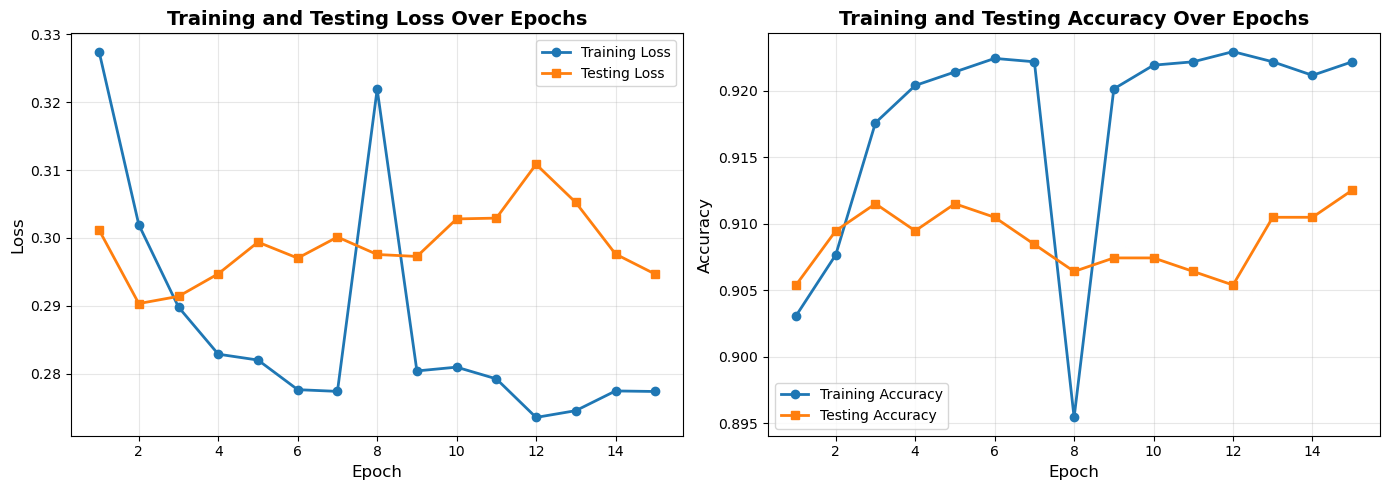


Final Results:
  Best Training Accuracy: 0.9229
  Best Testing Accuracy: 0.9125


In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, EPOCHS + 1), train_losses, 'o-', label='Training Loss', linewidth=2)
ax1.plot(range(1, EPOCHS + 1), test_losses, 's-', label='Testing Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Testing Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, EPOCHS + 1), train_accuracies, 'o-', label='Training Accuracy', linewidth=2)
ax2.plot(range(1, EPOCHS + 1), test_accuracies, 's-', label='Testing Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Testing Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"  Best Training Accuracy: {max(train_accuracies):.4f}")
print(f"  Best Testing Accuracy: {max(test_accuracies):.4f}")

## Make Predictions on New Reviews

Test the model on sample reviews with confidence scores

In [ ]:
def predict_sentiment(review_text, model, vocab, sequence_length, device):
    """
    Predict sentiment for a single review
    
    Args:
        review_text: String containing the review
        model: Trained RNN model
        vocab: Word-to-index vocabulary
        sequence_length: Fixed length for padding
        device: Device to run inference on
    
    Returns:
        sentiment: 'Positive' or 'Negative'
        confidence: Confidence score (0-1)
        rating: Estimated rating (1-5 based on confidence)
    """
    model.eval()
    
    cleaned = clean_text(review_text)
    tokens = tokenize(cleaned)
    sequence = tokens_to_sequence(tokens, vocab)
    padded = pad_sequence(sequence, sequence_length)
    
    input_tensor = torch.LongTensor([padded]).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        confidence = output.item()
    
    sentiment = "Positive" if confidence >= 0.5 else "Negative"
    
    # Estimate rating (1-5 scale)
    # Map confidence [0, 1] to rating scale
    if sentiment == "Positive":
        # Confidence 0.5-1.0 maps to ratings 4-5
        rating = 4 + (confidence - 0.5) * 2
    else:
        # Confidence 0.0-0.5 maps to ratings 1-3
        rating = 1 + confidence * 4
    
    return sentiment, confidence, rating

# Test on sample reviews from the test set
print("="*80)
print("PREDICTIONS ON TEST SET SAMPLES")
print("="*80)

sample_indices = np.random.choice(len(X_test), 5, replace=False)

for idx in sample_indices:
    original_idx = df.index[len(X_train) + idx]
    review_text = df.loc[original_idx, 'reviewText']
    true_sentiment = "Positive" if df.loc[original_idx, 'sentiment'] == 1 else "Negative"
    true_rating = df.loc[original_idx, 'overall']
    
    pred_sentiment, confidence, pred_rating = predict_sentiment(
        review_text, modelRNN, vocab, sequence_length, device
    )
    
    print(f"\nReview: {review_text[:100]}...")
    print(f"True Sentiment: {true_sentiment} (Rating: {true_rating})")
    print(f"Predicted: {pred_sentiment} | Confidence: {confidence:.4f} | Est. Rating: {pred_rating:.2f}")
    print("-"*80)

PREDICTIONS ON TEST SET SAMPLES

Review: pretty good! had a hiccup then they were pretty helpful and fixing the problem! used for my go pro a...
True Sentiment: Positive (Rating: 5.0)
Predicted: Positive | Confidence: 0.9283 | Est. Rating: 4.86
--------------------------------------------------------------------------------

Review: Works great for the month I have had it in my Galaxy S3.  I purchased this to go in my Samsung Galax...
True Sentiment: Positive (Rating: 4.0)
Predicted: Positive | Confidence: 0.9441 | Est. Rating: 4.89
--------------------------------------------------------------------------------

Review: I am only giving this product 3 stars becuse I purchased this one as a replacement for a SanDisk mic...
True Sentiment: Negative (Rating: 3.0)
Predicted: Positive | Confidence: 0.9283 | Est. Rating: 4.86
--------------------------------------------------------------------------------

Review: I gave away my last card to a friend who needed one.  After reading the revie

In [38]:
# Test on custom reviews (new unseen reviews)
print("\n" + "="*80)
print("PREDICTIONS ON NEW CUSTOM REVIEWS")
print("="*80)

custom_reviews = [
    "This product is absolutely amazing! Best purchase I've ever made. Highly recommend!",
    "Terrible quality. Broke after one day. Complete waste of money.",
    "It's okay, nothing special. Does what it's supposed to do.",
    "Love it! Exactly what I needed. Fast shipping and great quality.",
    "Do not buy this! Very disappointed with the quality and performance.",
    "Decent product for the price. Works as expected."
]

for review in custom_reviews:
    sentiment, confidence, rating = predict_sentiment(
        review, modelRNN, vocab, sequence_length, device
    )
    
    print(f"\nReview: {review}")
    print(f"Predicted: {sentiment} | Confidence: {confidence:.4f} | Est. Rating: {rating:.2f}/5.0")
    print("-"*80)


PREDICTIONS ON NEW CUSTOM REVIEWS

Review: This product is absolutely amazing! Best purchase I've ever made. Highly recommend!
Predicted: Positive | Confidence: 0.9283 | Est. Rating: 4.86/5.0
--------------------------------------------------------------------------------

Review: Terrible quality. Broke after one day. Complete waste of money.
Predicted: Positive | Confidence: 0.9283 | Est. Rating: 4.86/5.0
--------------------------------------------------------------------------------

Review: It's okay, nothing special. Does what it's supposed to do.
Predicted: Positive | Confidence: 0.9283 | Est. Rating: 4.86/5.0
--------------------------------------------------------------------------------

Review: Love it! Exactly what I needed. Fast shipping and great quality.
Predicted: Positive | Confidence: 0.9283 | Est. Rating: 4.86/5.0
--------------------------------------------------------------------------------

Review: Do not buy this! Very disappointed with the quality and performa

## Try with LSTM

In [ ]:
class SentimentLSTM(nn.Module):
    """
    LSTM model for sentiment classification
    
    Architecture:
    1. Embedding layer: Converts word indices to dense vectors
    2. LSTM layer: Processes sequential data with long-term memory
    3. Fully connected layer: Outputs binary sentiment prediction
    
    LSTM advantages over RNN:
    - Better at capturing long-term dependencies
    - Mitigates vanishing gradient problem
    - Has memory cells with gates (input, forget, output)
    """
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=128, num_layers=2, dropout=0.3):
        super(SentimentLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(hidden_size, 1)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        """
        Forward pass through the network
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length)
        
        Returns:
            logits: Tensor of shape (batch_size,) with raw logits (no sigmoid)
        """
        embedded = self.embedding(x)
        
        out, (hidden, cell) = self.lstm(embedded)
        
        last_output = out[:, -1, :]
        
        last_output = self.dropout(last_output)
        
        logits = self.fc(last_output)
        
        return logits.squeeze()

modelLSTM = SentimentLSTM(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_size=128,
    num_layers=2,
    dropout=0.35
).to(device)

print(f"LSTM Parameters: {sum(p.numel() for p in modelLSTM.parameters()):,}")
print("="*80)

LSTM Parameters: 804,097


## Train the model

In [ ]:
num_positive = np.sum(y_train == 1)
num_negative = np.sum(y_train == 0)
pos_weight = torch.tensor([num_negative / num_positive], dtype=torch.float32).to(device)

print(f"Class distribution in training set:")
print(f"  Positive: {num_positive} ({num_positive/len(y_train)*100:.1f}%)")
print(f"  Negative: {num_negative} ({num_negative/len(y_train)*100:.1f}%)")
print(f"  Positive weight: {pos_weight.item():.4f}")

# Use BCEWithLogitsLoss with pos_weight to handle class imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(modelLSTM.parameters(), lr=0.001)

print("\nLoss function: BCEWithLogitsLoss (with class weighting)")
print("Optimizer: Adam (lr=0.001)")

Class distribution in training set:
  Positive: 3558 (90.5%)
  Negative: 373 (9.5%)
  Positive weight: 0.1048

Loss function: BCEWithLogitsLoss (with class weighting)
Optimizer: Adam (lr=0.001)


In [ ]:
EPOCHS = 30

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Early stopping parameters
patience = 5
best_test_loss = float('inf')
patience_counter = 0

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Gradient clipping value
max_grad_norm = 1.0

print("Starting training with improvements:")
print(f"  - Early stopping (patience={patience})")
print(f"  - Gradient clipping (max_norm={max_grad_norm})")
print(f"  - Learning rate scheduler (ReduceLROnPlateau)\n")

for epoch in range(1, EPOCHS + 1):
    # ========== Training Phase ==========
    modelLSTM.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (xb, yb) in enumerate(train_loader):
        xb, yb = xb.to(device), yb.to(device)
        
        logits = modelLSTM(xb)
        loss = criterion(logits, yb)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(modelLSTM.parameters(), max_grad_norm)
        
        optimizer.step()
        
        train_loss += loss.item() * xb.size(0)
        predictions = torch.sigmoid(logits)
        predicted_labels = (predictions >= 0.5).float()
        train_correct += (predicted_labels == yb).sum().item()
        train_total += yb.size(0)
    
    avg_train_loss = train_loss / train_total
    train_accuracy = train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # ========== Testing Phase ==========
    modelLSTM.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            logits = modelLSTM(xb)
            loss = criterion(logits, yb)
            
            test_loss += loss.item() * xb.size(0)
            predictions = torch.sigmoid(logits)
            predicted_labels = (predictions >= 0.5).float()
            test_correct += (predicted_labels == yb).sum().item()
            test_total += yb.size(0)
    
    avg_test_loss = test_loss / test_total
    test_accuracy = test_correct / test_total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
    
    # Learning rate scheduler step
    scheduler.step(avg_test_loss)
    
    # Early stopping check
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
          f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.4f} | "
          f"Patience: {patience_counter}/{patience}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}")
        print(f"Best test loss: {best_test_loss:.4f}")
        break

print("\nTraining completed!")

Starting training with improvements:
  - Early stopping (patience=5)
  - Gradient clipping (max_norm=1.0)
  - Learning rate scheduler (ReduceLROnPlateau)

Epoch 01/30 | Train Loss: 0.1329 | Train Acc: 0.7293 | Test Loss: 0.1326 | Test Acc: 0.9054 | Patience: 0/5
Epoch 02/30 | Train Loss: 0.1329 | Train Acc: 0.4752 | Test Loss: 0.1311 | Test Acc: 0.6928 | Patience: 0/5
Epoch 03/30 | Train Loss: 0.1330 | Train Acc: 0.5286 | Test Loss: 0.1309 | Test Acc: 0.9064 | Patience: 0/5
Epoch 04/30 | Train Loss: 0.1316 | Train Acc: 0.5200 | Test Loss: 0.1306 | Test Acc: 0.0966 | Patience: 0/5
Epoch 05/30 | Train Loss: 0.1317 | Train Acc: 0.4727 | Test Loss: 0.1278 | Test Acc: 0.5585 | Patience: 0/5
Epoch 06/30 | Train Loss: 0.1277 | Train Acc: 0.7390 | Test Loss: 0.1246 | Test Acc: 0.7579 | Patience: 0/5
Epoch 07/30 | Train Loss: 0.1252 | Train Acc: 0.7718 | Test Loss: 0.1251 | Test Acc: 0.9054 | Patience: 1/5
Epoch 08/30 | Train Loss: 0.1236 | Train Acc: 0.8303 | Test Loss: 0.1237 | Test Acc: 0.90

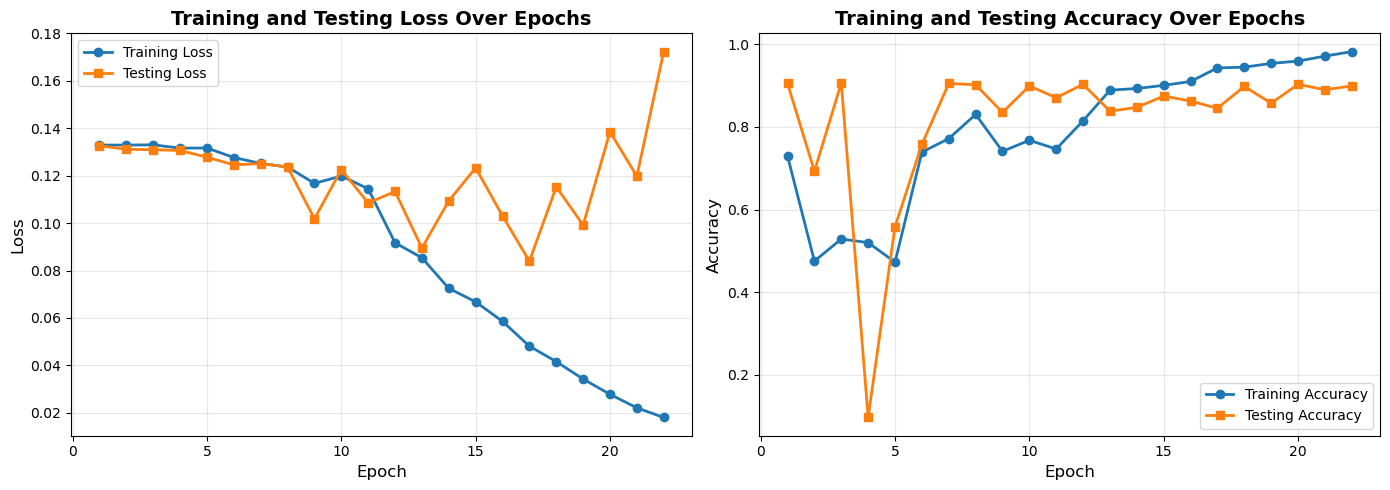


Final Results:
  Epochs trained: 22
  Best Training Accuracy: 0.9824
  Best Testing Accuracy: 0.9064


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_trained = len(train_losses)

ax1.plot(range(1, epochs_trained + 1), train_losses, 'o-', label='Training Loss', linewidth=2)
ax1.plot(range(1, epochs_trained + 1), test_losses, 's-', label='Testing Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Testing Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, epochs_trained + 1), train_accuracies, 'o-', label='Training Accuracy', linewidth=2)
ax2.plot(range(1, epochs_trained + 1), test_accuracies, 's-', label='Testing Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Testing Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"  Epochs trained: {epochs_trained}")
print(f"  Best Training Accuracy: {max(train_accuracies):.4f}")
print(f"  Best Testing Accuracy: {max(test_accuracies):.4f}")

In [ ]:
def predict_sentiment(review_text, model, vocab, sequence_length, device):
    """
    Predict sentiment for a single review
    
    Args:
        review_text: String containing the review
        model: Trained LSTM model
        vocab: Word-to-index vocabulary
        sequence_length: Fixed length for padding
        device: Device to run inference on
    
    Returns:
        sentiment: 'Positive' or 'Negative'
        confidence: Confidence score (0-1)
        rating: Estimated rating (1-5 based on confidence)
    """
    model.eval()
    
    cleaned = clean_text(review_text)
    tokens = tokenize(cleaned)
    sequence = tokens_to_sequence(tokens, vocab)
    padded = pad_sequence(sequence, sequence_length)
    
    input_tensor = torch.LongTensor([padded]).to(device)
    
    with torch.no_grad():
        logits = model(input_tensor)
        confidence = torch.sigmoid(logits).item()
    
    sentiment = "Positive" if confidence >= 0.5 else "Negative"
    
    if sentiment == "Positive":
        rating = 4 + (confidence - 0.5) * 2
    else:
        rating = 1 + confidence * 4
    
    return sentiment, confidence, rating

# Test on sample reviews from the test set
print("="*80)
print("PREDICTIONS ON TEST SET SAMPLES")
print("="*80)

sample_indices = np.random.choice(len(X_test), 5, replace=False)

for idx in sample_indices:
    original_idx = df.index[len(X_train) + idx]
    review_text = df.loc[original_idx, 'reviewText']
    true_sentiment = "Positive" if df.loc[original_idx, 'sentiment'] == 1 else "Negative"
    true_rating = df.loc[original_idx, 'overall']
    
    pred_sentiment, confidence, pred_rating = predict_sentiment(
        review_text, modelLSTM, vocab, sequence_length, device
    )
    
    print(f"\nReview: {review_text[:100]}...")
    print(f"True Sentiment: {true_sentiment} (Rating: {true_rating})")
    print(f"Predicted: {pred_sentiment} | Confidence: {confidence:.4f} | Est. Rating: {pred_rating:.2f}")
    print("-"*80)

PREDICTIONS ON TEST SET SAMPLES

Review: Correctly priced. I bought it to use with my surface pro. Works great out of the box and transfer sp...
True Sentiment: Positive (Rating: 5.0)
Predicted: Positive | Confidence: 0.9802 | Est. Rating: 4.96
--------------------------------------------------------------------------------

Review: Haven't had a problem using these with my Hero3 yet. It comes with the little plastic thing to conne...
True Sentiment: Positive (Rating: 5.0)
Predicted: Positive | Confidence: 0.9802 | Est. Rating: 4.96
--------------------------------------------------------------------------------

Review: With most of the world's electronic devices finally standardizing to SD (thank you Sony for finally ...
True Sentiment: Positive (Rating: 5.0)
Predicted: Positive | Confidence: 0.9882 | Est. Rating: 4.98
--------------------------------------------------------------------------------

Review: Not much you can say about a memory card. It works or it doesn't.Popped this 

In [76]:
# Test on custom reviews (new unseen reviews)
print("\n" + "="*80)
print("PREDICTIONS ON NEW CUSTOM REVIEWS")
print("="*80)

custom_reviews = [
    "This product is absolutely amazing! Best purchase I've ever made. Highly recommend!",
    "Terrible quality. Broke after one day. Complete waste of money.",
    "It's okay, nothing special. Does what it's supposed to do.",
    "Love it! Exactly what I needed. Fast shipping and great quality.",
    "Do not buy this! Very disappointed with the quality and performance.",
    "Decent product for the price. Works as expected."
]

for review in custom_reviews:
    sentiment, confidence, rating = predict_sentiment(
        review, modelLSTM, vocab, sequence_length, device
    )
    
    print(f"\nReview: {review}")
    print(f"Predicted: {sentiment} | Confidence: {confidence:.4f} | Est. Rating: {rating:.2f}/5.0")
    print("-"*80)


PREDICTIONS ON NEW CUSTOM REVIEWS

Review: This product is absolutely amazing! Best purchase I've ever made. Highly recommend!
Predicted: Positive | Confidence: 0.9801 | Est. Rating: 4.96/5.0
--------------------------------------------------------------------------------

Review: Terrible quality. Broke after one day. Complete waste of money.
Predicted: Negative | Confidence: 0.0290 | Est. Rating: 1.12/5.0
--------------------------------------------------------------------------------

Review: It's okay, nothing special. Does what it's supposed to do.
Predicted: Positive | Confidence: 0.9375 | Est. Rating: 4.87/5.0
--------------------------------------------------------------------------------

Review: Love it! Exactly what I needed. Fast shipping and great quality.
Predicted: Positive | Confidence: 0.9802 | Est. Rating: 4.96/5.0
--------------------------------------------------------------------------------

Review: Do not buy this! Very disappointed with the quality and performa